In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from statsmodels.graphics.tsaplots import plot_acf
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import PowerTransformer


# Importing data and processing for modelling

In [86]:
match_data = pd.read_csv('/Users/jon/Documents/fpl_points_prediction/ERD/tables/match_data.csv', delimiter=";", index_col=False)
player_match_data = pd.read_csv('/Users/jon/Documents/fpl_points_prediction/ERD/tables/player_match_data_withid.csv', delimiter=";", index_col=False)

#Merge main two tables
merged_data = player_match_data.merge(match_data, left_on='match_id', right_on='match_id', how='outer')
merged_data = merged_data.drop('value', axis=1)
merged_data = merged_data.drop('own_goals', axis=1) #Variation isn't large enough 104
merged_data = merged_data.drop('red_cards', axis=1) #Variation isn't large enough 111
merged_data = merged_data.drop('npxG', axis=1) #not using npg
merged_data = merged_data.drop('player_match_id', axis=1)

#Turning 'home' and 'away' into players team and opponent team for analysis
merged_data['p_team_spi'] = merged_data.apply(lambda row: row.h_team_spi if row.was_home == 1 else row.a_team_spi, axis=1)
merged_data['oppn_spi'] = merged_data.apply(lambda row: row.a_team_spi if row.was_home == 1 else row.h_team_spi, axis=1)
merged_data['prob_p_team_win'] = merged_data.apply(lambda row: row.prob_h_win if row.was_home == 1 else row.prob_a_win, axis=1)
merged_data['prob_oppn_win'] = merged_data.apply(lambda row: row.prob_a_win if row.was_home == 1 else row.prob_h_win, axis=1)
merged_data['p_team_proj_score'] = merged_data.apply(lambda row: row.h_proj_score if row.was_home == 1 else row.a_proj_score, axis=1)
merged_data['oppn_team_proj_score'] = merged_data.apply(lambda row: row.a_proj_score if row.was_home == 1 else row.h_proj_score, axis=1)
merged_data['importance_p_team'] = merged_data.apply(lambda row: row.importance_h if row.was_home == 1 else row.importance_a, axis=1)
merged_data['importance_oppn_team'] = merged_data.apply(lambda row: row.importance_a if row.was_home == 1 else row.importance_h, axis=1)
#merged_data['score_p_team'] = merged_data.apply(lambda row: row.h_score if row.was_home == 1 else row.a_score, axis=1)
#merged_data['score_oppn_team'] = merged_data.apply(lambda row: row.a_score if row.was_home == 1 else row.h_score, axis=1)
#merged_data['xg_p_team'] = merged_data.apply(lambda row: row.h_xg if row.was_home == 1 else row.a_xg, axis=1)
#merged_data['xg_oppn_team'] = merged_data.apply(lambda row: row.a_xg if row.was_home == 1 else row.h_xg, axis=1)
#Additional features created
merged_data['opp_adv_spi'] = merged_data['oppn_spi'] - merged_data['p_team_spi']

#Creating lagged varibaled and lagged moving average varibales
#Sort values by player_id and date
lagged_data = merged_data.sort_values(['player_id', 'date'])

#Total points
def average_form(var):
    lagged_data[var+'-1'] = lagged_data.groupby('player_id')[var].shift(1) #Lagged once
    lagged_data[var+'-2'] = lagged_data.groupby('player_id')[var].shift(2) #Lagged twice
    lagged_data[var+'-3'] = lagged_data.groupby('player_id')[var].shift(3) #etc.
    lagged_data[var+'-4'] = lagged_data.groupby('player_id')[var].shift(4)
    lagged_data[var+'_lag_avg2'] = (lagged_data[var+'-1'] + lagged_data[var+'-2'])/2 #lagged 2 week moving average 
    lagged_data[var+'_lag_avg3'] = (lagged_data[var+'-1'] + lagged_data[var+'-2'] + lagged_data[var+'-3'])/3 #lagged 3 week moving average
    lagged_data[var+'_lag_avg4'] = (lagged_data[var+'-1'] + lagged_data[var+'-2'] + lagged_data[var+'-3'] + lagged_data[var+'-4'])/4 #etc.

for i, var in enumerate(['total_points','xP','bonus','bps','minutes','goals','shots','xG','xA','assists','key_passes','npg','xGChain','xGBuildup','yellow_cards','clean_sheets','goals_conceded','penalties_missed','penalties_saved','saves','influence','creativity','threat','ict_index']):
    average_form(var)

#remove date now used for lagging
lagged_data = lagged_data.drop('date', axis=1)
#Drop rows with NaN values caused by lagging.
lagged_data = lagged_data.dropna() 

#Drop game specific data that is not needed for the model
lagged_data = lagged_data.drop(['xP', 'bonus', 'minutes','bps', 'goals', 'shots', 'xG', 'xA',
       'assists', 'key_passes', 'npg', 'xGChain', 'xGBuildup', 'yellow_cards', 'clean_sheets', 'goals_conceded',
       'penalties_missed', 'penalties_saved', 'saves', 'influence',
       'creativity', 'threat', 'ict_index', 'round', 'h_team_spi', 'a_team_spi', 'prob_h_win', 'prob_a_win',
       'h_proj_score', 'a_proj_score', 'importance_h', 'importance_a',
       'h_score', 'a_score', 'h_xg', 'a_xg', 'match_id', 'season_id_y'], axis=1)

#'minutes', better with minutes included. 'season_id_x'
#lagged_data = lagged_data[lagged_data['minutes_lag_avg4'] > 60]

In [79]:
#Additional features that could be created
#merged_data['points_per_90'] = merged_data['total_points']/(90/merged_data['minutes'])
##Creating lagged varibales and lagged moving average varibales for home and away form for each team
#Creating lagged varibales and lagged moving average varibales for home and away form for each player
#lagged_data = merged_data.sort_values(['player_id', 'was_home','date'])
lagged_data.columns

Index(['player_id', 'position_id', 'player_team_id', 'was_home', 'season_id_x',
       'total_points', 'minutes', 'selected', 'transfers_in', 'transfers_out',
       ...
       'threat_lag_avg2', 'threat_lag_avg3', 'threat_lag_avg4', 'ict_index-1',
       'ict_index-2', 'ict_index-3', 'ict_index-4', 'ict_index_lag_avg2',
       'ict_index_lag_avg3', 'ict_index_lag_avg4'],
      dtype='object', length=192)

# - Regression 1
Running a baseline regresison on all observations and all varibales including lagged variables just to see how it performs. Expectations are low.

In [82]:
#Pipeline

def split_X_y(df, target_col):
    # Split dataframe into X and y
    X = df.drop(target_col, axis=1)
    y = df[target_col]
    return X, y

def split_data(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

def scale_features(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train) #.fit - fits model with mean and std
    X_train_scaled =pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled = scaler.transform(X_test) #NO need to fit anymore becuase mean and std have been defined in the training phase. You then use the test data on the model
    X_test_scaled=pd.DataFrame(X_test_scaled, columns=X_test.columns)
    return X_train_scaled, X_test_scaled

def build_linear_regression_model(X_train, y_train):
    # Create a linear regression object
    lr = LinearRegression()
    # Train the model using the training data
    lr.fit(X_train, y_train)
    # Return the trained model
    return lr

def predict_regression_model(model, X_train, y_train, X_test):
    # Make predictions on the training data
    y_train_pred = model.predict(X_train)
    # Make predictions on the test data
    y_test_pred = model.predict(X_test)
    # Return the predicted values for both sets
    return y_train_pred, y_test_pred

def report_regression_metrics(y_train, y_test, y_train_pred, y_test_pred):
    # Calculate mean absolute error (MAE) for train and test sets
    train_mae = round(mean_absolute_error(y_train, y_train_pred),2)
    test_mae = round(mean_absolute_error(y_test, y_test_pred),2)
    print('\nTrain Mean Absolute Error:', train_mae)
    print('Test Mean Absolute Error:', test_mae)
    
    # Calculate mean squared error (MSE) for train and test sets
    train_mse = round(mean_squared_error(y_train, y_train_pred),2)
    test_mse = round(mean_squared_error(y_test, y_test_pred),2)
    print('\nTrain Mean Squared Error:', train_mse)
    print('Test Mean Squared Error:', test_mse)
    
    # Calculate root mean squared error (RMSE) for train and test sets
    train_rmse = round(np.sqrt(train_mse),2)
    test_rmse = round(np.sqrt(test_mse),2)
    print('\nTrain Root Mean Squared Error:', train_rmse)
    print('Test Root Mean Squared Error:', test_rmse)
    
    # Calculate R-squared value for train and test sets
    train_r2 = round(r2_score(y_train, y_train_pred),2)
    test_r2 = round(r2_score(y_test, y_test_pred),2)
    print('\nTrain R-squared:', train_r2)
    print('Test R-squared:', test_r2)

def plot_regression_results(y_test, y_pred,title="On Test Set"):
    residuals = y_test - y_pred
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle("Regression Results - "+ title, fontsize=16)

    # Residual plot
    sns.scatterplot(x=y_pred, y=residuals, ax=axs[0])
    axs[0].axhline(y=0, color='r', linestyle='--')
    axs[0].set_xlabel('Predicted Values')
    axs[0].set_ylabel('Residuals')
    axs[0].set_title('Residual Plot')
    
    # Actual versus predicted plot
    sns.scatterplot(x=y_test, y=y_pred, ax=axs[1])
    axs[1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    axs[1].set_xlabel('Actual Values')
    axs[1].set_ylabel('Predicted Values')
    axs[1].set_title('Actual versus Predicted')
    
    # Residual histogram
    sns.histplot(x=residuals, ax=axs[2], kde=True)
    axs[2].set_xlabel('Residuals')
    axs[2].set_ylabel('Count')
    axs[2].set_title(f'Residual Histogram (RMSE = {rmse:.2f})')
    
    # Rotate x-axis tick labels in all subplots
    for ax in axs:
        ax.tick_params(axis='x', labelrotation=45)
        
    fig.tight_layout()

def report_coef_train(model, feature_names):
    coef = pd.DataFrame(model.coef_, columns=['Coefficient'], index=feature_names)
    intercept = pd.DataFrame([model.intercept_], columns=['Intercept'], index=[''])
    return pd.concat([coef, intercept])

def plot_feature_importances(model, X_train, FN):
    # Get absolute value of coefficients
    coefs = np.abs(model.coef_)
    
    # Normalize coefficients
    coefs /= np.sum(coefs)
    
    # Sort coefficients by importance
    sorted_idx = np.argsort(coefs)
    
    # Get feature names
    feature_names = X_train.columns.values
    
    # Select number of features
    n_features = FN
    top_sorted_idx = sorted_idx[-n_features:]
    top_coefs = coefs[top_sorted_idx]
    top_feature_names = feature_names[top_sorted_idx]

    plt.figure(figsize=(8, 5))
    # Plot horizontal bar chart of top feature importances
    plt.barh(range(len(top_sorted_idx)), top_coefs, align='center')
    plt.yticks(range(len(top_sorted_idx)), top_feature_names)
    # set the tick label font size and other parameters
    plt.tick_params(axis='both', which='major', labelsize=6, length=6, width=2, direction='out', pad=8)

    plt.xlabel('Normalized Feature Importance')
    plt.ylabel('Feature')
    plt.title('Top {} Feature Importances'.format(n_features))
    plt.show()


Train Mean Absolute Error: 2.2
Test Mean Absolute Error: 2.24

Train Mean Squared Error: 8.65
Test Mean Squared Error: 9.06

Train Root Mean Squared Error: 2.94
Test Root Mean Squared Error: 3.01

Train R-squared: 0.09
Test R-squared: 0.08


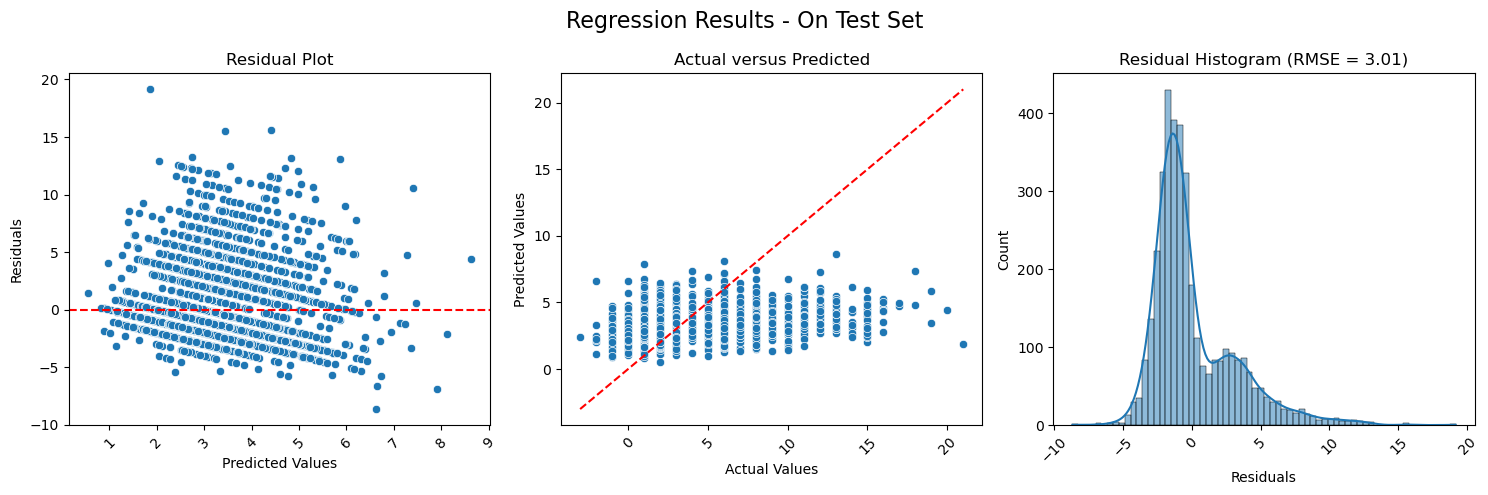

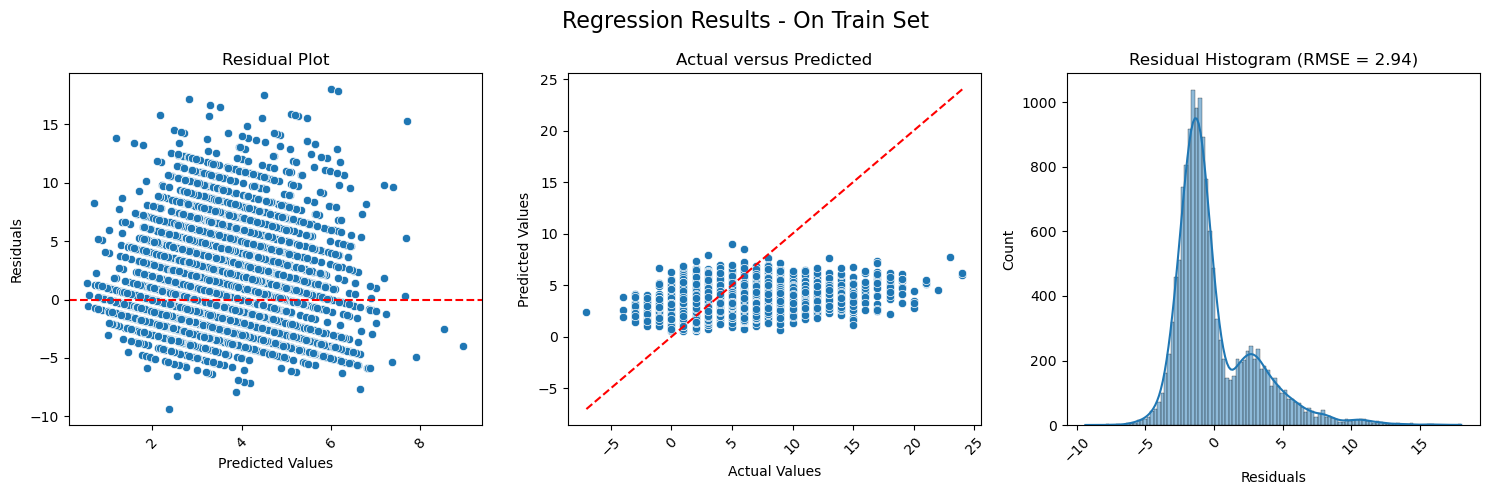

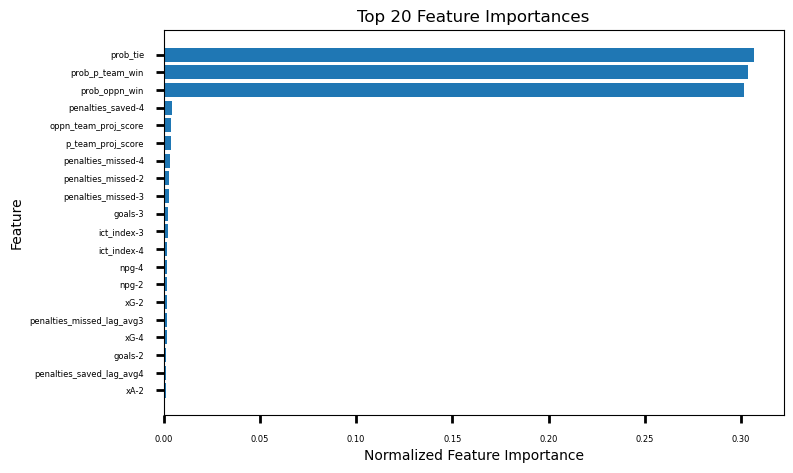

In [85]:
#Create model

# Split the dataset into X and y
X, y = split_X_y(lagged_data, "total_points")
# Split the data into train and test sets
X_train, X_test, y_train, y_test = split_data(X, y)
#Fit LR model on training data
lr=build_linear_regression_model(X_train, y_train)
# make predictions using linear regression
y_train_pred, y_test_pred= predict_regression_model(lr, X_train, y_train, X_test)

#Results 

#Get metrics
report_regression_metrics(y_train, y_test, y_train_pred, y_test_pred)
# Plot the regression results
plot_regression_results(y_test, y_test_pred,"On Test Set")
plot_regression_results(y_train, y_train_pred,"On Train Set")
#Get coefficients
report_coef_train(lr, X_train.columns)
## plot linear regression feature importances
plot_feature_importances(lr, X_train, 20)

This model works badly as expected because the total points achieved by half the players is 1 or 2.
I will try to improve this model with scaling.

Standard Scalar will standardize the distribution of the independent variables. The resulting transformed variables will have a mean of 0 and a standard deviation of 1, which can be useful.
- Reduces the impact of outliers


In [87]:
# Split the dataset into X and y
X, y = split_X_y(lagged_data, "total_points")
# Split the data into train and test sets
X_train, X_test, y_train, y_test = split_data(X, y)

#Scaled X
X_train_scaled, X_test_scaled = scale_features(X_train, X_test)
# apply Yeo-Johnson transform to the training set only
pt = PowerTransformer(method='yeo-johnson')
y_train_transformed = pt.fit_transform(y_train.values.reshape(-1, 1))
# apply the same transformation to the test set
y_test_transformed = pt.transform(y_test.values.reshape(-1, 1))


model = build_linear_regression_model(X_train_scaled, y_train_transformed)
y_train_pred, y_test_pred = predict_regression_model(model, X_train_scaled, y_train_transformed, X_test_scaled)

#Get metrics
report_regression_metrics(y_train_transformed, y_test_transformed, y_train_pred, y_test_pred)


#results are just as bad


Train Mean Absolute Error: 0.69
Test Mean Absolute Error: 0.71

Train Mean Squared Error: 0.89
Test Mean Squared Error: 0.93

Train Root Mean Squared Error: 0.94
Test Root Mean Squared Error: 0.96

Train R-squared: 0.11
Test R-squared: 0.09


Try splitting data by position. FWD, MID, GKP, DEF
Makes no difference to the model

In [94]:
lagged_data_position = lagged_data[lagged_data['position_id'] == 1]
#lagged_data_position = lagged_data[lagged_data['position_id'] == 2]
#lagged_data_position = lagged_data[lagged_data['position_id'] == 3]
#lagged_data_position = lagged_data[lagged_data['position_id'] == 4]
#lagged_data_nomins = lagged_data[lagged_data['minutes_lag_avg4'] > 60]

X, y = split_X_y(lagged_data_position, "total_points")
X_train, X_test, y_train, y_test = split_data(X, y)

model=build_linear_regression_model(X_train, y_train)
y_train_pred, y_test_pred= predict_regression_model(model, X_train, y_train, X_test)
report_regression_metrics(y_train, y_test, y_train_pred, y_test_pred)


Train Mean Absolute Error: 1.81
Test Mean Absolute Error: 1.73

Train Mean Squared Error: 7.43
Test Mean Squared Error: 6.68

Train Root Mean Squared Error: 2.73
Test Root Mean Squared Error: 2.58

Train R-squared: 0.13
Test R-squared: 0.12


In [78]:
lagged_data_position = lagged_data[lagged_data['position_id'] == 1]
#lagged_data_position = lagged_data[lagged_data['position_id'] == 2]
#lagged_data_position = lagged_data[lagged_data['position_id'] == 3]
#lagged_data_position = lagged_data[lagged_data['position_id'] == 4]
X, y = split_X_y(lagged_data_position, "total_points")
X_train, X_test, y_train, y_test = split_data(X, y)

#scale
X_train_scaled, X_test_scaled = scale_features(X_train, X_test)
# apply Yeo-Johnson transform to the training set only
pt = PowerTransformer(method='yeo-johnson')
y_train_transformed = pt.fit_transform(y_train.values.reshape(-1, 1))
# apply the same transformation to the test set
y_test_transformed = pt.transform(y_test.values.reshape(-1, 1))


model = build_linear_regression_model(X_train_scaled, y_train_transformed)
y_train_pred, y_test_pred = predict_regression_model(model, X_train_scaled, y_train_transformed, X_test_scaled)

#Get metrics
report_regression_metrics(y_train_transformed, y_test_transformed, y_train_pred, y_test_pred)


Train Mean Absolute Error: 0.57
Test Mean Absolute Error: 0.56

Train Mean Squared Error: 0.71
Test Mean Squared Error: 0.66

Train Root Mean Squared Error: 0.84
Test Root Mean Squared Error: 0.81

Train R-squared: 0.29
Test R-squared: 0.3


In [ ]:
#Remove correlated items?

corr = merged_data[['selected', 'transfers_in',
       'transfers_out', 'p_team_spi', 'oppn_spi', 'prob_p_team_win', 'prob_oppn_win',
       'prob_tie', 'p_team_proj_score', 'oppn_team_proj_score', 'importance_p_team',
       'importance_oppn_team', 'opp_adv_spi']].corr()
s = corr.unstack()
so = s.sort_values(kind="quicksort")
print(so)